<h2 style = 'color: blue'> Auto Encoders <h2>


In this notebook, we start by implementing a vanilla AutoEncoder and then modify it to learn the distribution of the input instead of its features. The actual meaning of the features is determined and learned by the model as it processes the inputs and their corresponding outputs. Then we will make it convolutional and compare the results.

In [4]:
''' Import required libraries '''

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import random
import matplotlib.pyplot as plt 
from torchvision import transforms, datasets

<h4 style = 'color: green'> First we explore the dataset <h4>


In [2]:
batch_size = 64

t = transforms.Compose([
    transforms.ToTensor()
])

data = datasets.MNIST(root='mnist/', download=True, transform=t)
train, test = random_split(data, [50000, 10000])

train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100%|██████████| 9.91M/9.91M [00:14<00:00, 665kB/s] 


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100%|██████████| 28.9k/28.9k [00:00<00:00, 171kB/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw



Visualize some random samples from the dataset 

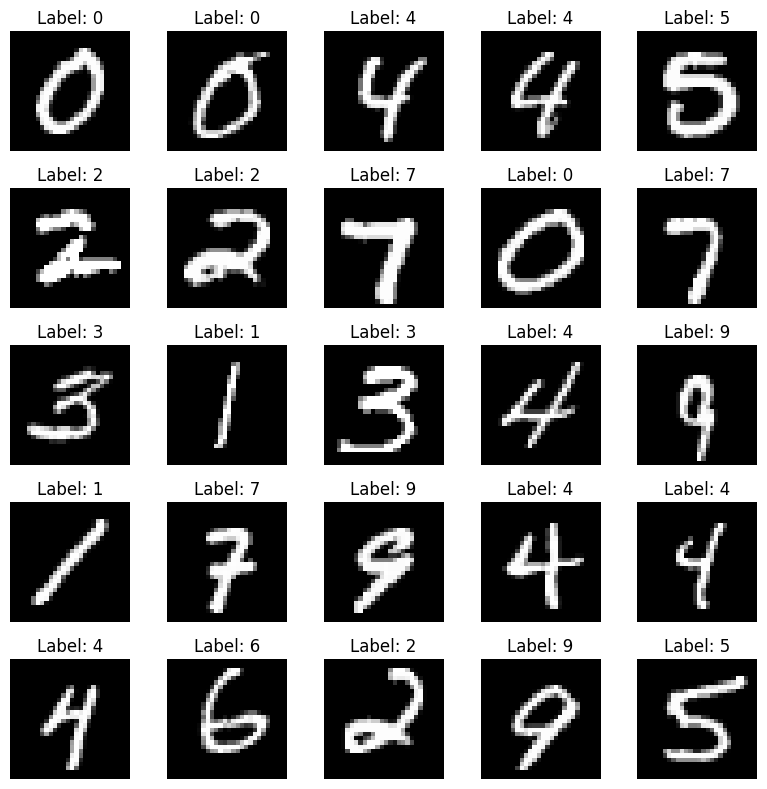

In [3]:
''' visualization '''
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()


<img  style = "height: 500px; display: flex; justify-content: center;" src = 'https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/vanilla-AE.png?size=630x472&lossy=2&strip=1&webp=1'>


Imagine we have a 28x28 pixel image. We save n features of this image, and later, we can reconstruct the image using just these features. There's a magical machine that knows how to extract these n features from the original image, and another machine that knows how to reconstruct the image based on those features. When training an AutoEncoder, these two machines, called the encoder and decoder, learn how to perform these operations.

The encoder learns how to compress the image into a smaller feature space, while the decoder learns how to reconstruct the original image from this compressed representation.

<h4 style = 'color: green'> Here you implement an AutoEncoder <h4>


In [9]:
''' AutoEncoder class '''

class AE(torch.nn.Module):

    def __init__(self, inputSize, hiddenSize, featureSize):

        super(AE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, featureSize),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(featureSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, inputSize),
            nn.Sigmoid()
        )  

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded



Before we start training and evaluation, let's implement a variation of this model. During inference, in the traditional AutoEncoder, each image is mapped to a fixed vector of features, and the model is strict about this exact representation. Instead of using fixed numbers, we can keep a distribution, allowing for smoother interpolation in the feature space.

To achieve this, we introduce two vectors for each image: one representing the mean, and the other representing the log of the variance. Both vectors have the same size as the original feature space. In other words, we now have the parameters required to define a unique normal distribution for each image.

<img  style = "height: 500px; display: flex; justify-content: center;" src = 'https://github.com/bvezilic/Variational-autoencoder/raw/master/assets/VAE.001.jpeg'>


During decoding, instead of using a fixed feature vector, we sample from this distribution to build the features. This makes our model more flexible and generative, allowing it to create variations of images similar to those in the training dataset.

<div style="color: orange;">
  <h3>Now you might ask two questions:</h3>
  <ul>
    <li>Why do we keep the logarithm of the variance instead of the standard deviation?</li>
    <p>In short, it's due to numerical instability. If you're not convinced, you can check 
      <a href="https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig" style="color: blue;">here</a>.
    </p>
    <li>How and where do we reparameterize?</li>
    <p>All you need to do during reparameterization is to compute the standard deviation using the formula:</p>
    <p style="font-weight: bold; text-align: center;">std = e<sup>0.5 * logvar</sup></p>
    <p>This can be implemented in the reparameterization function within the class below.</p>
  
  </ul>
</div>


<h4 style = 'color: green'> Now you implement a Variational AutoEncoder <h4>


In [18]:
''' Variational AutoEncoder class '''

class VAE(AE):
    """
    You can either implement it from the beginning or use the AE class you implemented.
    """

    def __init__(self, inputSize, hiddenSize, featureSize):

        super().__init__(inputSize, hiddenSize, featureSize)
        self.enc_hidden = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.ReLU(),
        )
        # Separate linear layers for mu and logVar
        self.mu_layer = nn.Linear(hiddenSize, featureSize)
        self.logVar_layer = nn.Linear(hiddenSize, featureSize)

        # For the decoder, we can keep it the same as AE
        self.decoder = nn.Sequential(
            nn.Linear(featureSize, hiddenSize),
            nn.ReLU(),
            nn.Linear(hiddenSize, inputSize),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)  
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, input):
        # 1. encoding
        hidden = self.enc_hidden(input)
        
        # 2. computing mu & logVar
        mu = self.mu_layer(hidden)
        logVar = self.logVar_layer(hidden)
        
        # 3. sampling z
        z = self.reparameterize(mu, logVar)
        
        # 4. decoding
        reconstruction = self.decoder(z)
        
        return reconstruction, mu, logVar

<h4 style = 'color: green'> Here, we first train the AE and then the VAE <h4>


In [14]:
''' Train loop '''
input_size   = 784
hidden_size  = 256
feature_size = 64
lr = 1e-3 
model = AE(input_size , hidden_size , feature_size)
optimizer = torch.optim.Adam(model.parameters(), lr = lr )
loss = nn.MSELoss() 

for epoch in range(30):
    for images, _ in train_loader:
        # Flatten
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss_value = loss(outputs, images)

        # Backprop and optimize
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{30}], Loss: {loss_value.item():.4f}")

Epoch [1/30], Loss: 0.0187
Epoch [2/30], Loss: 0.0124
Epoch [3/30], Loss: 0.0102
Epoch [4/30], Loss: 0.0097
Epoch [5/30], Loss: 0.0071
Epoch [6/30], Loss: 0.0062
Epoch [7/30], Loss: 0.0075
Epoch [8/30], Loss: 0.0058
Epoch [9/30], Loss: 0.0058
Epoch [10/30], Loss: 0.0056
Epoch [11/30], Loss: 0.0056
Epoch [12/30], Loss: 0.0043
Epoch [13/30], Loss: 0.0056
Epoch [14/30], Loss: 0.0048
Epoch [15/30], Loss: 0.0045
Epoch [16/30], Loss: 0.0046
Epoch [17/30], Loss: 0.0051
Epoch [18/30], Loss: 0.0044
Epoch [19/30], Loss: 0.0039
Epoch [20/30], Loss: 0.0057
Epoch [21/30], Loss: 0.0049
Epoch [22/30], Loss: 0.0046
Epoch [23/30], Loss: 0.0042
Epoch [24/30], Loss: 0.0040
Epoch [25/30], Loss: 0.0051
Epoch [26/30], Loss: 0.0043
Epoch [27/30], Loss: 0.0053
Epoch [28/30], Loss: 0.0040
Epoch [29/30], Loss: 0.0036
Epoch [30/30], Loss: 0.0035


Implement a function that takes the model and the number of images as inputs, samples random images from your test dataset, and displays both the original and reconstructed images.

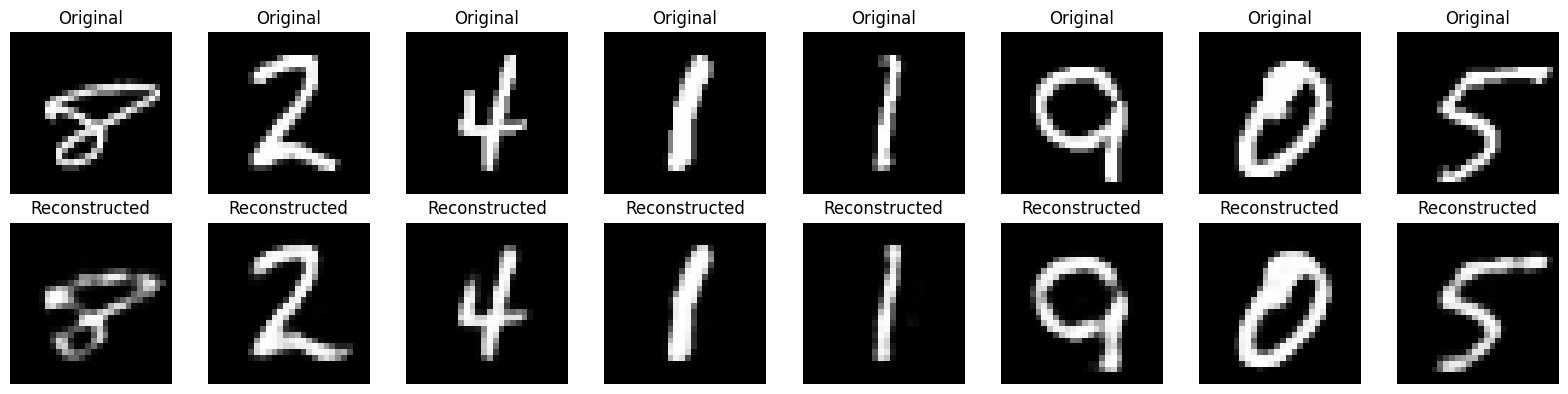

In [17]:
''' evaluation '''
def visualize_reconstructions(model, dataset, num_images=5, device='cpu'):
    model.eval() 
    
    # Randomly sample indices
    indices = random.sample(range(len(dataset)), num_images)
    images = []
    for idx in indices:
        img, _ = dataset[idx]  # dataset returns (image, label)
        images.append(img)
    images_tensor = torch.stack(images).to(device)
    images_tensor = images_tensor.view(images_tensor.size(0), -1)

    with torch.no_grad():
        reconstructions = model(images_tensor)
    # Plot original vs. reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(2*num_images, 4))
    for i in range(num_images):
        # Original image
        original_img = images[i].cpu().squeeze()
        
        # Reconstruction
        reconstructed_img = reconstructions[i].cpu().view(28, 28)

        # Top row: Original
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        # Bottom row: Reconstruction
        axes[1, i].imshow(reconstructed_img, cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_reconstructions(model, test, num_images=8, device='cpu')

<h4 style = 'color: green'> Now we do exactly the same but this time for the VAE <h4>


Here, KL is a good choice, so we consider this loss with the proper weight in our training loop.

The KL (Kullback-Leibler) loss measures the difference between two probability distributions. In Variational Autoencoders (VAEs), KL loss ensures that the learned latent space follows a standard normal distribution.

The formula for KL loss is:

$
\text{KL}(q(z \mid x) \| p(z)) = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$


In [21]:
''' Train loop '''
def vae_loss_function(recon_x, x, mu, logVar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
    
    return recon_loss + kl_div

input_size = 784
hidden_size = 256
feature_size = 64
lr = 1e-3
ephocs = 30

# Initialize the model
model = VAE(input_size, hidden_size, feature_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Sample training loop
for epoch in range(ephocs):
    total_loss = 0
    for images, _ in train_loader:
        # Flatten
        images = images.view(images.size(0), -1)

        # Forward pass
        recon, mu, logVar = model(images)
        
        # Compute loss
        loss = vae_loss_function(recon, images, mu, logVar)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{ephocs}], Loss: {avg_loss:.4f}")


Epoch [1/30], Loss: 166.8013
Epoch [2/30], Loss: 128.4967
Epoch [3/30], Loss: 118.7190
Epoch [4/30], Loss: 114.2032
Epoch [5/30], Loss: 111.7124
Epoch [6/30], Loss: 110.2225
Epoch [7/30], Loss: 109.2003
Epoch [8/30], Loss: 108.4501
Epoch [9/30], Loss: 107.9453
Epoch [10/30], Loss: 107.4858
Epoch [11/30], Loss: 107.1008
Epoch [12/30], Loss: 106.7907
Epoch [13/30], Loss: 106.5954
Epoch [14/30], Loss: 106.2830
Epoch [15/30], Loss: 106.1120
Epoch [16/30], Loss: 105.9315
Epoch [17/30], Loss: 105.7287
Epoch [18/30], Loss: 105.6238
Epoch [19/30], Loss: 105.4445
Epoch [20/30], Loss: 105.3417
Epoch [21/30], Loss: 105.2415
Epoch [22/30], Loss: 105.1231
Epoch [23/30], Loss: 105.0120
Epoch [24/30], Loss: 104.9083
Epoch [25/30], Loss: 104.8700
Epoch [26/30], Loss: 104.7361
Epoch [27/30], Loss: 104.6341
Epoch [28/30], Loss: 104.5754
Epoch [29/30], Loss: 104.5567
Epoch [30/30], Loss: 104.4822


Same as you did, compare the constructed images and original ones but this time with the VAE model

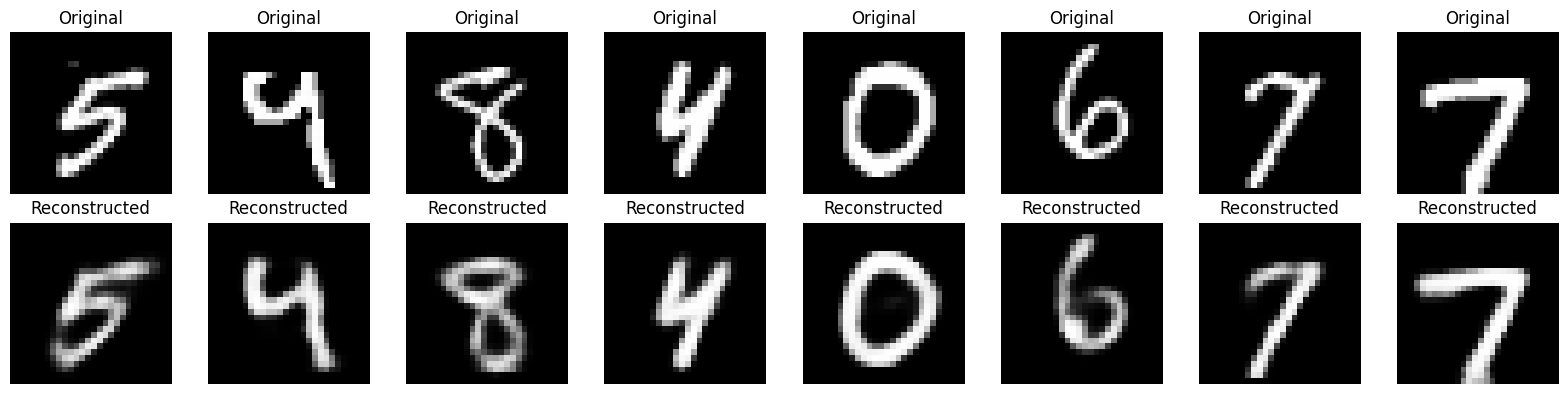

In [22]:
''' evaluation '''
def visualize_vae_recon(vae, dataset, num_images=5, device='cpu'):
    vae.eval()
    indices = random.sample(range(len(dataset)), num_images)
    images = []
    for idx in indices:
        img, _ = dataset[idx]
        images.append(img)

    images_tensor = torch.stack(images).to(device)
    images_tensor = images_tensor.view(images_tensor.size(0), -1)

    with torch.no_grad():
        recon, _, _ = vae(images_tensor)
    
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
    for i in range(num_images):
        original_img = images[i].cpu().squeeze()
        recon_img = recon[i].cpu().view(28, 28)

        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_vae_recon(model, test, 8, 'cpu')

This time, we modify the VAE to process the input using convolutional layers. Implement a convolutional VAE with an architecture of your choice, but keep it as simple as possible.

In [28]:
class CNNVAE(torch.nn.Module):
    def __init__(self, latent_dim=16):
        super(CNNVAE, self).__init__()

        # 1. encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32, 7, 7)
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(32 * 7 * 7, 128)
        
        # 2. compute mu and logvar
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # 3. decoder
        self.dec_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            # First Deconv: (32, 7, 7) -> (16, 14, 14)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            # Second Deconv: (16, 14, 14) -> (1, 28, 28)
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_conv(x)           
        h = h.view(h.size(0), -1)          
        h = nn.functional.relu(self.enc_fc(h))         
        mu = self.fc_mu(h)                 
        logVar = self.fc_logvar(h)        
        return mu, logVar
    
    def decode(self, z):
        h = self.dec_fc(z)                 
        h = h.view(h.size(0), 32, 7, 7)    
        x_recon = self.decoder_conv(h)     
        return x_recon
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        x_recon = self.decode(z)
        return x_recon, mu, logVar

Train your convolutional VAE model (same as you did for VAE)

In [31]:
''' Train loop '''

def vae_loss_function(x_recon, x, mu, logVar):
    x_recon_flat = x_recon.view(x_recon.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    
    # 1. Reconstruction loss
    recon_loss = nn.functional.binary_cross_entropy(x_recon_flat, x_flat, reduction='sum')
    
    # 2. KL Divergence
    kl_div = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
    return recon_loss + kl_div

model = CNNVAE(latent_dim=16).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to('cpu')

        x_recon, mu, logVar = model(images)
        loss = vae_loss_function(x_recon, images, mu, logVar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

RuntimeError: The size of tensor a (16) must match the size of tensor b (64) at non-singleton dimension 1

Compare the reconstructed and original images as you did before, but for the model you have just trained

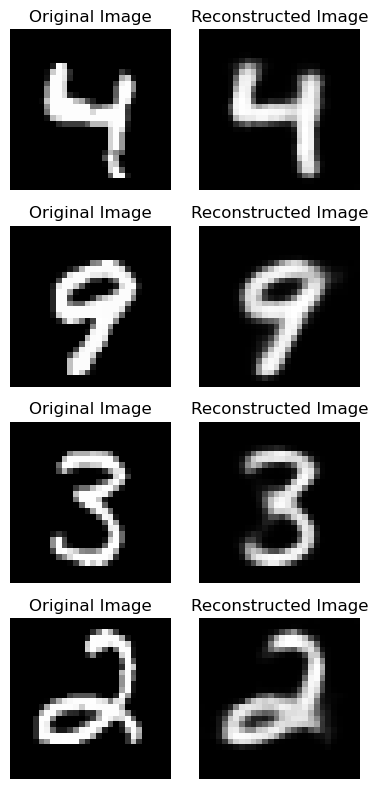

In [30]:
''' evaluation '''


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(MyConvVAE, self).__init__()
        # -----------------------------
        #  ENCODER
        # -----------------------------
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (B, 32, 7, 7)
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(32 * 7 * 7, 128)  # 32*7*7=1568 -> 128

        # produce mu, logvar (both of size latent_dim)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # -----------------------------
        #  DECODER
        # -----------------------------
        self.dec_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.Sigmoid()  # for MNIST [0,1]
        )

    def encode(self, x):
        # x shape: (B, 1, 28, 28)
        h = self.encoder_conv(x)         # (B, 32, 7, 7)
        h = h.view(h.size(0), -1)        # (B, 1568)
        h = F.relu(self.enc_fc(h))       # (B, 128)
        mu = self.fc_mu(h)               # (B, latent_dim)
        logvar = self.fc_logvar(h)       # (B, latent_dim)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec_fc(z)               # (B, 32*7*7)
        h = h.view(h.size(0), 32, 7, 7)  # (B, 32, 7, 7)
        x_recon = self.decoder_conv(h)   # (B, 1, 28, 28)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [33]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# If you have a DataLoader for MNIST that yields (B, 1, 28, 28):
# e.g. train_loader

device = 'cpu'  # or 'cuda' if you have CUDA installed
model = MyConvVAE(latent_dim=16).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

def vae_loss_function(x_recon, x, mu, logvar):
    x_recon_flat = x_recon.view(x_recon.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    recon_loss = F.binary_cross_entropy(x_recon_flat, x_flat, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

num_epochs = 1  # just test for shape
for epoch in range(num_epochs):
    model.train()
    for images, _ in train_loader:
        # Debug print:
        print("Batch images shape:", images.shape)  # Expect (B, 1, 28, 28)

        images = images.to(device)

        x_recon, mu, logvar = model(images)
        # Debug prints:
        print("x_recon shape:", x_recon.shape)  # Expect (B, 1, 28, 28)
        print("mu shape:", mu.shape)            # Expect (B, 16)
        print("logvar shape:", logvar.shape)    # Expect (B, 16)
        
        loss = vae_loss_function(x_recon, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Just break after first batch to confirm shapes
        break
    break


Batch images shape: torch.Size([64, 1, 28, 28])
x_recon shape: torch.Size([64, 1, 28, 28])
mu shape: torch.Size([64, 16])
logvar shape: torch.Size([64, 16])
